# **Laboratorio 2:** Data Version Control

Similar a Git y Github, Data Version Control (DVC) es una herramienta que permite la descentralización del dataset o datasets que fueran a utilizarse en un proyecto, de manera que podamos gestionar diferentes versiones de un dataset en distintas ubicaciones y/o en la nube. Esto permite trabajar en proyectos de ciencia de datos, donde parte del equipo estará recogiendo y etiquetando nuevas muestras, otra parte del equipo estará entrenando los modelos de manera separada y remota. Por otro lado, un equipo de QA podría monitorear los modelos en producción para alertar al equipo sobre cualquier anomalía. Gestionar las diferentes versiones del dataset en este escenario es obligatorio y en este laboratorio veremos un ejemplo de como realizar esta gestión.

<center><img src='https://miro.medium.com/max/700/1*gN7Xru3A-PTavPI6adpJPQ.png' width='40%'></center>

Se sugiriere realizar el presente laboratorio de manera local, ejecutando comandos en la terminal cuando se requiera, debido a que realizar commits hacia Github y guardar datos en Google Drive requiere autenticación, el cual no debería ser compartido en código. El presente laboratorio debe realizarse de manera grupal, por lo que bastara con que uno del equipo lo complete para su proyecto.




## 1. Descargar el dataset

Esta vez, usaremos el dataset MNIST desde la librería Scikit-learn, el cual es muy usado por la comunidad para primeros experimentos de Deep Learning y Machine Learning para reconocimiento de imágenes.


In [6]:
import time
#import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000


In [8]:
import matplotlib.pyplot as plt
import random

# El modulo datasets de scikitlearn permite descargar un dataset publico con bastante facilidad
# La lista de datasets disponibles se encuentra en https://scikit-learn.org/stable/datasets/toy_dataset.html
from sklearn.datasets import fetch_openml
# La función train_test_split sirve para dividir un dataset pasando como parametro
# a los datos y sus etiquetas
from sklearn.model_selection import train_test_split

# Descargar dataset mnist
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000
)

# Mostrar la longitud de los subconjuntos y sus anotaciones.
len(X_train), len(X_test), len(y_train), len(y_test)

ImportError: cannot import name 'animation' from partially initialized module 'matplotlib' (most likely due to a circular import) (C:\Users\hp\anaconda3\lib\site-packages\matplotlib\__init__.py)

In [4]:
# Podemos ver que el dataset descargado se encuentra en un array de Numpy y las imágenes
# se encuentran en formato de vectores de 784 elementos. Estos vectores deberan
# ser redimensionados para que las imágenes descargadas sean usables.
print(type(X_train), X_train.shape)

X_train = X_train.reshape(len(X_train),28,28)
X_test = X_test.reshape(len(X_test),28,28)

print(type(X_train), X_train.shape)


NameError: name 'X_train' is not defined

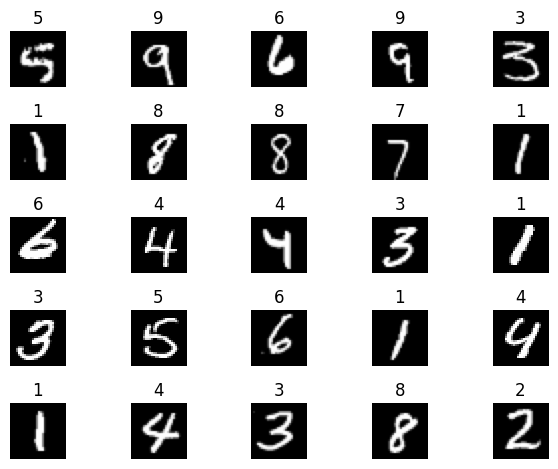

In [ ]:
def plot_samples(num_samples=25, subset_images=None, subset_labels=None):
	'''
		Esta función recibe como atributo a un conjunto de muestras en formato numpy,
		y las muestra en una cuadricula usando matplotlib.
	'''
	# Definir el tamaño de la figura a generarse con Matplotlib
	fig = plt.figure(dpi=100)
	# Mostrar una muestra de n imágenes
	for ix in range(num_samples):
		ax = plt.subplot(5, 5, ix + 1)

		# Seleccionar aleatoriamente un indice del subconjunto de entrenamiento
		i = random.randint(0, len(subset_images)-1)
		# Extraer la imagen y etiqueta
		img, label = subset_images[i], subset_labels[i]
		# Plotear la imagen y agregar la etiqueta como titulo
		ax.imshow(img, cmap='gray')
		ax.set_title(label)
		# Eliminar ejes horizontales y verticales
		ax.axis('off')
	# Ajustar el espacio entre los sub graficos
	plt.tight_layout()
	plt.show()

plot_samples(25, X_train, y_train)

## 2. Crear un dataset de ejemplo

Para esta primera versión, usaremos una parte pequeña del dataset MNIST (200 imágenes) y solo mantendremos las etiquetas del digito 7, tomando en cuenta que todos los otros dígitos tienen una mista etiqueta (No dígito 7). Esta versión del dataset podría servirnos para realizar una tarea de clasificación binaria de imágenes. Además, esto también nos servira para ejemplificar la generación de nuevas versiones del dataset.

In [ ]:
import numpy as np

# Filtrar 100 imagenes con la etiqueta '7'
X_train_7 = X_train[y_train == '7'][:100]
y_train_7 = y_train[y_train == '7'][:100]
# Filtrar 100 imagenes sin la etiqueta '7'
X_train_no_7 = X_train[y_train != '7'][:100]
y_train_no_7 = y_train[y_train != '7'][:100]

len(X_train_7), len(X_train_no_7)

(100, 100)

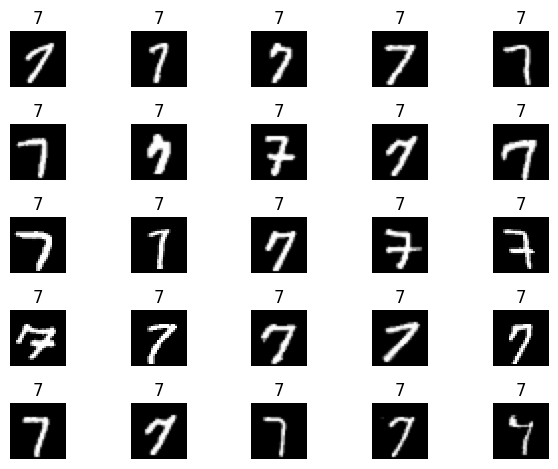

In [ ]:
plot_samples(25, X_train_7, y_train_7)

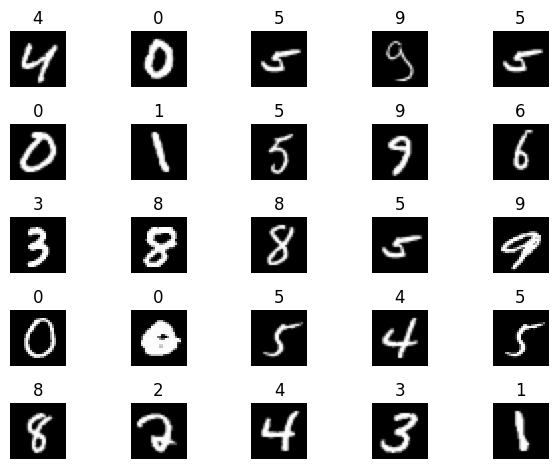

In [ ]:
plot_samples(25, X_train_no_7, y_train_no_7)

## 3. Guardar y ordenar los archivos del dataset

Hasta esta etapa, ya tenemos nuestros subconjuntos filtrados en los arrays de numpy `X_train_7` y `X_train_no_7`. Sin embargo, estas variables (arrays de numpy) tienen las imágenes en la ram y requerimos que estén guardadas en el disco duro. En consecuencia, ahora copiaremos y ordenaremos los archivos hacia una nueva carpeta, la cual contendrá nuestra primera versión del dataset.

In [ ]:
import os
import shutil

# Path permite representar rutas en formato de objetos
# e integrar rutas con el operador /, para luegar transformar estas a rutas del sistema
# operativo con el que se este trabajando
from pathlib import Path
# Skimage es una librería parte de Scikitlearn para el procesamiento de imágenes,
# en esta ocasión solo lo usaremos para guardar imágenes. Por otro lado imread
# permite leer imágenes.
from skimage.io import imsave, imread
# La librería glob permite generar listado de archivos usando caracteres especiales (* o ?)
# para generalizar los posibles archivos con una sola extensión en una carpeta
from glob import glob

def generate_dataset(path, images_first_category, images_second_category, test_size):
	'''
		Esta función ordena a las imagenes (disponibles en dos arrays Numpy/subconjuntos)
		en subcarpetas tomando en cuenta las categorías. La función
		retorna las rutas de los nuevos archivos en arrays de listas
	'''
	# Si existe la carpeta dataset
	if os.path.exists(path):
		# Eliminar el arbol de directorios completo
		shutil.rmtree(path)
 	# Crear la carpeta 'dataset'
	os.makedirs(path, exist_ok=True)

	# Crear carpetas destino
	splits = ['train', 'test']
	for split in splits:
		os.makedirs(path / split, exist_ok=True)
		os.makedirs(path / split / '7', exist_ok=True)
		os.makedirs(path / split / 'no7', exist_ok=True)

		# Crear los dataframes para train y para test, tomando en cuenta el tamaño
		# del subconjunto de evaluación
		if split == 'train':
			X1, X2 = images_first_category[:-test_size], images_second_category[:-test_size]
		else:
			X1, X2 = images_first_category[-test_size:], images_second_category[-test_size:]

		# Iterar en los subconjuntos de muestras que contienen 3 y los que no,
		# guardando las imágenes respectivas
		for x1, x2 in zip(X1, X2):
			# La función imsave requiere una ruta objetivo para guardar la imagen,
			# y esta imagen debe estar en formato Numpy. También redimensionaremos
			# las imágenes para que tengan 28x28 pixeles.
			imsave(path / split / '7' / f'{random.randint(0, 99999):05d}.png', x1.astype('uint8'))
			imsave(path / split / 'no7' / f'{random.randint(0, 99999):05d}.png', x2.astype('uint8'))

	# Obtener listas con las rutas de las imagenes, para cada subconjunto
	train_7 = glob(str(path / 'train' / '7' / '*.png'))
	train_no7 = glob(str(path / 'train' / 'no7' / '*.png'))
	test_7 = glob(str(path / 'test' / '7' / '*.png'))
	test_no7 = glob(str(path / 'test' / 'no7' / '*.png'))

	return train_7, train_no7, test_7, test_no7

# Crear la carpeta que contendra el proyecto
!mkdir project
%cd project

# Definir la ruta del nuevo dataset
new_dataset_path = Path('dataset')

# Ordenar y guardar un dataset de acuerdo a dos arrays de Numpy que contengan
# instancias para dos categorías (X_train_3, X_train_no_3)
train_7, train_no7, test_7, test_no7 = generate_dataset(new_dataset_path, X_train_7, X_train_no_7, 20)

# Mostrar los tamaños de los nuevos subconjuntos generados
len(train_7), len(train_no7), len(test_7), len(test_no7)

/content/project


(80, 80, 20, 20)

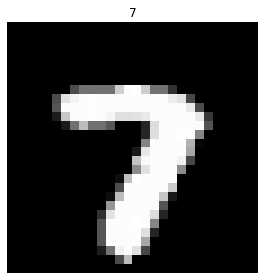

In [ ]:
# Mostrar una imagen y su etiqueta desde las rutas guardadas en una lista
def show_sample(paths,label):
	i = random.randint(0, len(paths)-1)
	img = imread(paths[i])
	plt.title(label)
	plt.imshow(img, cmap='gray')
	plt.axis('off')
	plt.tight_layout()
	plt.show()

show_sample(train_7,"7")

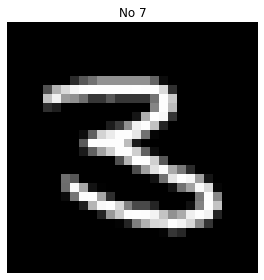

In [ ]:
show_sample(train_no7,"No 7")

## 4. Versionado del dataset

Hasta esta etapa, ya tenemos organizado nuestro dataset y este se encuentra listo para ser procesado por un modelo de clasificación binaria de digitos (digitos 7 y cualquier otro digito). Sin embargo, el dataset irá evolucionando en el futuro, añadiendo más imágenes y clases. La opción más sencilla para manejar esto sería generar un `.zip` con nuestros datos, ponerle un nombre (por ejemplo, mnist-v1.0) y guardarlo en algún servidor, al cual puedan acceder los miembros de nuestro equipo para entrenar modelos. Sin embargo, no es la mejor estrategía cuando son muchas las versiones que tenemos. En consecuencia, usaremos los conocimientos adquiridos sobre Git y Github para realizar esta tarea de mejor manera. `DVC` trabaja en conjunto con `git`, así que lo primero que necesitaremos será un repositorio de `git` que puedes alojar en `Github`. En mi caso he creado este [repositorio](https://github.com/EdwinTSalcedo/dvc) para este laboratorio.

Posterior a esto, sincronizaremos la carpeta local con una carpeta de GDrive en la nube. La siguiente celda contiene las instrucciones para realizar esta sincronización. Es recomendable ejecutar las siguientes celdas de manera local, con la terminal de su sistema operativo.

### 4.1. Inicializar un repositorio en Git y sincronizarlo con Github (Ejecutar en la terminal)

In [ ]:
# Definir mi identidad
!git config --global user.email "ingedwinsalcedo@gmail.com"
!git config --global user.name "Edwin Salcedo"

# Inicializar un repositorio git
!git init

# Agregaremos un archivo .gitignore para que nos ayude a ignorar la carpeta dataset
# la cual debe ser controlada por DVC y no por Git
!echo "dataset" > .gitignore
!git add .
!git commit -m "First commit"
!git remote add origin git@github.com:EdwinTSalcedo/DVC.git
!git push origin master

### 4.2 Inicializar un repositorio DVC y sincronizarlo con Gdrive (Ejecutar en la terminal)

Deberás ejectuar los siguientes comandos al mismo nivel que el de git, ya que `dvc` utiliza git para el control de version de los metadatos asociados a los datos (archivos grandes). Esto generará una carpeta `.dvc` y un archivo `.dvcignore` similar a git.

In [ ]:
# Instalar dvc
!pip install dvc

# Inicializar repositorio
!dvc init

# Añadir la carpeta con los datos al repositorio dvc con el comando
!dvc add dataset

Hasta este punto, ya estamos haciendo seguimiento de versiones de nuestro dataset con `dvc`. Esta herramienta permite subir datasets a una variedad de servicios como Google Drive, Firebase, Amazon AWS, entre otros. Puedes utilizar diferentes servicios, [aquí](https://dvc.org/doc/command-reference/remote) tienes un tutorial sobre el comando `remote` que permite agregar repositorios remotos. En este caso utilizaremos [Google Drive](https://drive.google.com/drive/u/0/my-drive) por ser el mas conocido, sin embargo, es bueno mencionar que el Gdrive tiene limites para guardar/transferir archivos, por lo que no es el mejor servicio para DVC. Por otra parte, Gdrive es gratuito a comparación de los otros servicios mencionados.

Para que `dvc` pueda acceder a la carpeta en la que deseamos guardar nuestro dataset en Gdrive, necesitaremos agregar el ID de la carpeta, el cual esta siempre disponible en la url de las carpetas de nuestro Gdrive. Al ejecutar la sincronización, Gdrive pedir permisos de acceso.

In [ ]:
# Agregar un repositorio remoto por defecto en la carpeta con codigo 0AIac4JZqHhKmUk9PDA en Google Drive
# Este codigo (ID) es parte de la url de nuestra carpeta en GDrive
!dvc remote add --default myremote gdrive://0AIac4JZqHhKmUk9PDA
# Sincronizar nuestro dataset
!dvc push

Ahora puedes probar a eliminar la carpeta `dataset` y para volver a recuperarla puedes ejecutar:

In [ ]:
!dvc pull dataset.dvc

Usaremos `git` para crear una nueva versión del dataset. `git` guardará los archivos específicos de `dvc` del commit con el tag determinado.

In [ ]:
!git add .
!git commit -m "version 0"
!git tag -a v0 -m "version 0"
!git push origin master --tags

En este punto, cualquiera con acceso al repositorio de `git` y con las credenciales necesarias de `Gdrive` podrá acceder al dataset y a todas sus versiones de manera sencilla y remota para usarlo para entrenar modelos o modificarlo y crear nuevas versiones. Simplemente, usando el siguiente comando:

In [ ]:
!dvc pull

## 5. Crear nueva versión del dataset

Ahora vamos a generar una nueva versión del dataset con 100 muestras más de las que teníamos anteriormente.

In [ ]:
X_train_7 = X_train[y_train == '7'][:200]
X_train_no_7 = X_train[y_train != '7'][:200]

len(X_train_7), len(X_train_no_7)

In [ ]:
new_dataset_path = Path('dataset')

train_7, train_no7, test_7, test_no7 = generate_dataset(new_dataset_path, X_train_7, X_train_no_7, 40)
len(train_7), len(train_no7), len(test_7), len(test_no7)

Utilizaremos los comando vistos anteriormente para crear una nueva versión.

In [ ]:
!dvc add dataset
!dvc push
!git add .
!git commit -m 'version 1'
!git tag -a v1 -m "version 1"
!git push origin master --tags

Ahora que tenemos diferentes versiones podemos ir cambiando entre ellas de la siguiente manera.

In [ ]:
!git checkout tags/v0
!dvc pull

In [ ]:
# versión 0 con división de 80/20
print("Train - Label 7:",len(os.listdir("dataset/train/7")))
print("Train - Label No 7:",len(os.listdir("dataset/train/no7")))

print("Test - Label 7:",len(os.listdir("dataset/test/7")))
print("Test - Label No 7:",len(os.listdir("dataset/test/no7")))

Retornemos a la versión 1:

In [ ]:
!git checkout tags/v1
!dvc pull

In [ ]:
# Versión 1 con división de 160/40

print("Train - Label 7:",len(os.listdir("dataset/train/7")))
print("Train - Label No 7:",len(os.listdir("dataset/train/no7")))

print("Test - Label 7:",len(os.listdir("dataset/test/7")))
print("Test - Label No 7:",len(os.listdir("dataset/test/no7")))